## init

In [1]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils,
    examples as ex,
    sneaky_matrix as sneaky
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

from typing import *

import matplotlib.pyplot as plt
%matplotlib inline

import mars



def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}'
    if ex.prune_eps is not None:
        filename += f'-peps{ex.prune_eps}'
    filename += '.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4


# thing go bbrrr

|======== Timed report ========
| reduce sparse              :     399.62ms  (399.618ms per; #1)
| py reduce                  :     401.35ms  (401.352ms per; #1)
| vineyard.get_state_at_point:      49.71ms  ( 0.003ms per; #15444)
| reduce_vine: ordering      :   32487.70ms  ( 2.104ms per; #15444)
| from sparse                :      18.03ms  ( 3.006ms per; #6)
| mars.reduce_vine           :   40077.15ms  ( 2.595ms per; #15444)
| reduce_vine.almost-all     :   43087.78ms  ( 2.790ms per; #15444)
| py reduce_vine             :   75644.51ms  ( 4.898ms per; #15444)
| flood_fill_visit           :   76286.29ms  (76286.294ms per; #1)
|==============================


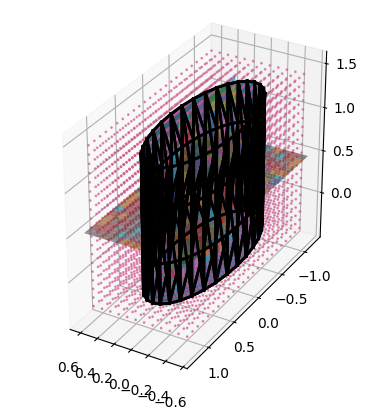

In [8]:
example = ex.squish_cyl


###################

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

faces = []
swaps = []
class vineyard2(vin.vineyard):
  def get_point_key(self, point: np.ndarray):
    return gridd.cell_of(point)
  
  def prune(self, s1: cplx.simplex, s2: cplx.simplex, old_state, new_state):
    swaps.append((s1, s2, old_state, new_state))

    if s1.dim() == example.medial_axis:
      per_1 = vin.compute_persistence(s1, old_state.ordering, old_state.R)
      per_2 = vin.compute_persistence(s2, new_state.ordering, new_state.R)
      if per_1 < 0.01 or per_2 < 0.01:
        return True

    return vin.prune_euclidean(our_complex, s1, s2, old_state.point, new_state.point, example.prune_eps)

  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, old_state, new_state):
    super().on_faustian(s1, s2, old_state.point, new_state.point)
    if s1.dim() == example.medial_axis:
      c1 = gridd.cell_of(old_state.point)
      c2 = gridd.cell_of(new_state.point)
      faces.append(gridd.dual_face(c1, c2))

v = vineyard2(our_complex)

n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    with utils.Timed('py reduce'):
      v.reduce(center_point)
  else:
    old_point = gridd.coordinate(old_cell)
    old_state = v.get_state_at_point(old_point)
    new_point = gridd.coordinate(new_cell)
    with utils.Timed('py reduce_vine'):
      v.reduce_vine(old_state, new_point)

with utils.Timed('flood_fill_visit'):
  gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

ourplot.plot_vineyard_results(our_complex, gridd, faces, CameraOpt(azim=120, elev=30))
export_obj(example, our_complex, faces)

num swaps  = 116637796
fausitans  = 66024
stored faces = 535
states = 5472
#vertices  = 128
#edges     = 384
#triangles = 256
grid size =  (12, 24, 19, 3)

bound = 63135111.111111104
ratio = 1.847
[15339, 10524, 32541, 25301, 32568, 29041, 11288, 33228, 24332, 33408, 28154, 10570, 35149, 24551, 31602, 27594, 13550, 11308, 29683, 34377, 29263, 14358, 9874, 17661, 29175, 26076, 13581, 11828, 32096, 25100, 24487, 13096, 10911, 30555, 26402, 21267, 11550, 33326, 25187, 32292, 29135, 12206, 29117, 34942, 29116, 11047, 18561, 31859, 23764, 10250, 32798, 24853, 25281, 9573, 30292, 25870, 21901, 8843, 33919, 23878, 30161, 27239, 10852, 27995, 32926, 29308, 9389, 17807, 28539, 25052, 9863, 33089, 24470, 25784, 11173, 32167, 26009, 21010, 13620, 10912, 21611, 32105, 26707, 13127, 11947, 29187, 23805, 12789, 11007, 27863, 21919, 12420, 10206, 15201, 27835, 23284, 12814, 10408, 18469, 21228, 12734, 9760, 17751, 17641, 13595, 9937, 29304, 24609, 17610, 11950, 8730, 28385, 22416, 15005, 9993, 34223,

Text(0.5, 1.0, 'Histogram of the nubmer of transpositions per run of vineyards')

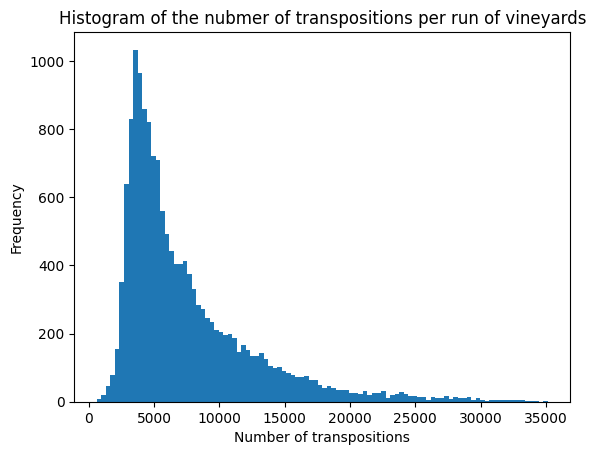

In [6]:
print(f'num swaps  = {v.num_swaps}')
print(f'fausitans  = {len(swaps)}')
print(f'stored faces = {len(faces)}')
print(f'#states = {len(v.state_map)}')

print()
V = len(our_complex.vertlist)
print(f'#vertices  = {V}')
E = len(our_complex.edgelist)
print(f'#edges     = {E}')
F = len(our_complex.trilist)
print(f'#triangles = {F}')
G = sum(gridd.a.shape[:3])
print(f'grid size = ', gridd.a.shape)


our_bound = V*(V-1)//2 * (G/3)**2 + E*(E-1) * (G/3)**2 + F*(F-1)//2 * (G/3)**2
print()
print(f'bound = {our_bound}')
print(f'ratio = {v.num_swaps / our_bound:.3f}')

print(v.swap_counts)
plt.hist(v.swap_counts, bins=100)
plt.xlabel('Number of transpositions')
plt.ylabel('Frequency')
plt.title('Histogram of the nubmer of transpositions per run of vineyards')

# 66024 faustian swaps
# 116'637'796 total swaps

# newest pruning

/var/folders/s5/np01y3nn239b1wb3m4fgt90m0000gn/T/ipykernel_19027/3328535485.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


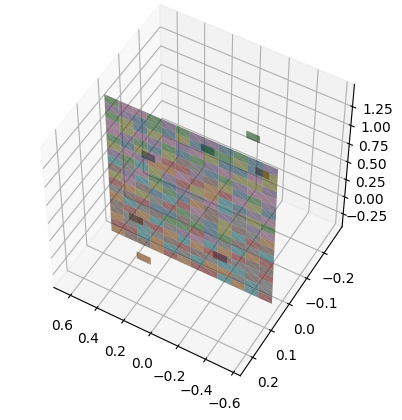

In [15]:
import math
med_ax_dim = 1
euc_prune_param = 8
conditional_pers_prune = True
always_pers_prune = True
persistence = 1*euc_prune_param
pers_prune_eps = .01 # default 0.01
##############################
# for eps in [5, 9.98 * 1 / math.sqrt(2), 10 / math.sqrt(2)]:
ffaces = []
for (s1, s2, a, b) in swaps:
  if vin.prune_euclidean(our_complex, s1, s2, a.point, b.point, euc_prune_param):
    continue
  # smarter prune? 
  if s1.dim() == med_ax_dim and conditional_pers_prune:
      if vin.prune_euclidean(our_complex, s1, s2, a.point, b.point, pers_euc) or always_pers_prune:
        per_1 = vin.compute_persistence(s1, a.ordering, a.R)
        per_2 = vin.compute_persistence(s2, b.ordering, b.R)
        if per_1 < persistence or per_2 < persistence:
          continue
  if s1.dim() == med_ax_dim:
    c1 = gridd.cell_of(a.point)
    c2 = gridd.cell_of(b.point)
    ffaces.append(gridd.dual_face(c1, c2))
fig, ax = ourplot.plot_vineyard_results(our_complex, gridd, ffaces, CameraOpt(azim=120, elev=50), skip_grid=True, skip_cube=True)
fig.show()
export_obj(example, our_complex, ffaces)